# "To log10 or not to log10?" that is the question.

## Motivation
With the WHONDRS data spanning many orders of magnitude, it would seem like a good idea to apply a log10 (or other transform) on the target with the TransformedTargetRegressor option on `scikit-learn` models. This means that all trained ML models with this option will automatically read in data, transform it, train or predict, and then apply the inverse transform.

In an ideal world, we could use the [Yeo-Johnson transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) because it does a good job handling a variety of cases.  In practice however, coupling the YJ transform (and other power transformers) to the hyperparameter optimization results in lots of internal NaN values that cause training to crash.  My guess is that the wide range of hyperparameters that we search through results in lots of off-the-wall values that the YJ transform is not prepared to handle.

So, in practice, I implemented my own [log10 transform/inverse](https://github.com/parallelworks/sl_core/blob/main/sample_inputs/superlearner_conf_TTR_mms_log10_neg.py) that uses both the log10 and **hard coded** (CAUTION!!!) limits to a MinMaxScaler for the WHONDRS data set. Since the MinMaxScaler is applied **after** the log10, this means that the MMS limits `[-2.0,4.0]` are orders of magnitude (i.e. 0.01 to 10000), not actual values. This notebook is designed to check how this log10 transformation performs compared to the standard approach which uses only (automated range) MinMaxScalers.

## Usage
To use this notebook, clone `dynamic-learning-rivers` (or another ML-archive repository).  Caution!!!! This code will switch branches in the repo to load the data and do side by side comparisions!!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Number of independent SuperLearners
num_sl = 10

In [2]:
!cd /pw/dev/dynamic-learning-rivers; git checkout test-y2023m09-w-log

Switched to branch 'test-y2023m09-w-log'
Your branch is up to date with 'origin/test-y2023m09-w-log'.


In [3]:
# Load the first superlearner to initialize storage
train_target_w_log = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_0/sl_scatter_train.csv')
test_target_w_log = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_0/sl_scatter_test.csv')

# Loop over each SuperLearner (start counting with 1 since already loaded 0)
for ll in np.linspace(1,num_sl-1,num_sl-1):
    print(ll)
    train = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_'+str(int(ll))+'/sl_scatter_train.csv')
    test = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_'+str(int(ll))+'/sl_scatter_test.csv')
    
    train_target_w_log = pd.concat([train_target_w_log, train])
    test_target_w_log = pd.concat([test_target_w_log, test])

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


In [4]:
!cd /pw/dev/dynamic-learning-rivers; git checkout test-y2023m09-no-log

Updating files: 100% (236/236), done.
Switched to branch 'test-y2023m09-no-log'
Your branch is up to date with 'origin/test-y2023m09-no-log'.


In [5]:
# Load the first superlearner to initialize storage
train_target_n_log = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_0/sl_scatter_train.csv')
test_target_n_log = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_0/sl_scatter_test.csv')

# Loop over each SuperLearner (start counting with 1 since already loaded 0)
for ll in np.linspace(1,num_sl-1,num_sl-1):
    print(ll)
    train = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_'+str(int(ll))+'/sl_scatter_train.csv')
    test = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_'+str(int(ll))+'/sl_scatter_test.csv')
    
    train_target_n_log = pd.concat([train_target_n_log, train])
    test_target_n_log = pd.concat([test_target_n_log, test])

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


(array([   9.,   18.,   23.,   25.,   40.,   41.,   46.,   21.,   22.,
        1385.]),
 array([-4285.42413751, -3858.43343723, -3431.44273696, -3004.45203669,
        -2577.46133641, -2150.47063614, -1723.47993587, -1296.48923559,
         -869.49853532,  -442.50783505,   -15.51713477]),
 <BarContainer object of 10 artists>)

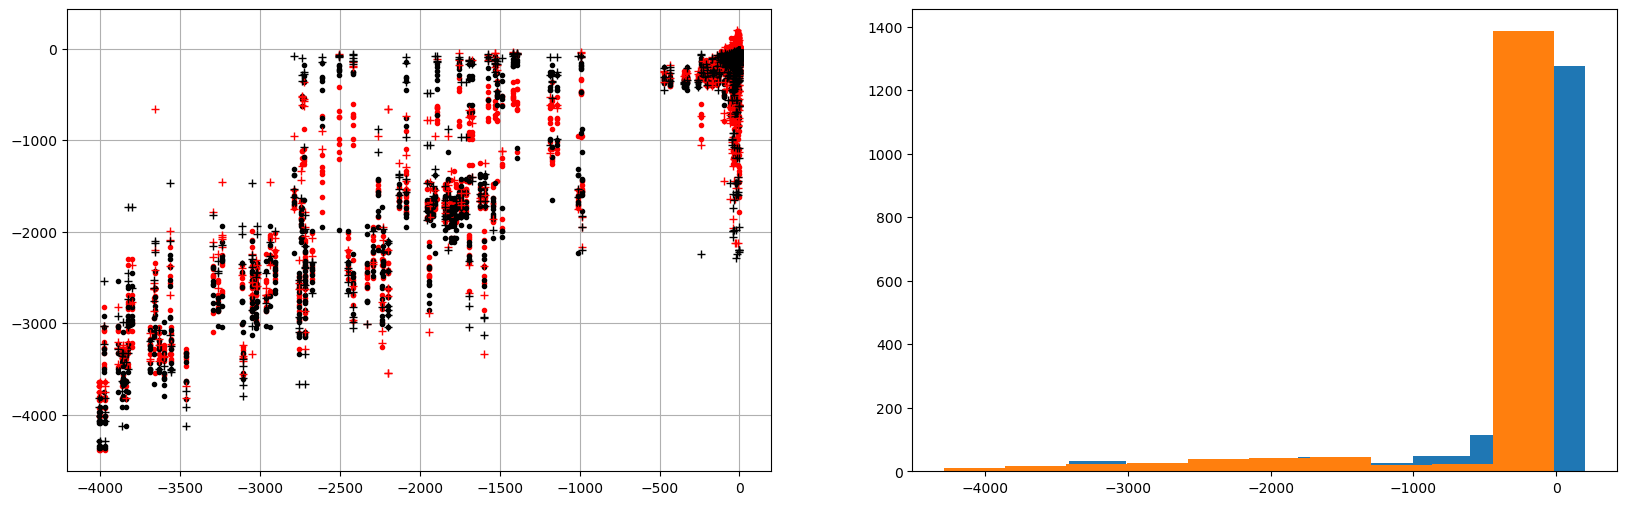

In [6]:
fig, [ax0,ax1] = plt.subplots(1,2,figsize=(20,6))
ax0.plot(train_target_n_log['target'],train_target_n_log['predicted'],'r.')
ax0.plot(train_target_w_log['target'],train_target_w_log['predicted'],'k.')
ax0.plot(test_target_n_log['target'],test_target_n_log['predicted'],'r+')
ax0.plot(test_target_w_log['target'],test_target_w_log['predicted'],'k+')
ax0.grid()

ax1.hist(test_target_n_log['predicted'])
ax1.hist(test_target_w_log['predicted'])

Scatter plot of target versus predicted values. Hard to tell which is better from the scatter.  But, what is obvious is that the custom transformer enforces that all predictions are negative.

Let's run correlations on the whole data set as well as the high and low values (-500 is a great cutoff).

In [7]:
train_w_log_small = np.squeeze(train_target_w_log[train_target_w_log['target'] >= -500.0])
test_w_log_small = np.squeeze(test_target_w_log[test_target_w_log['target'] >= -500.0])

train_n_log_small = np.squeeze(train_target_n_log[train_target_n_log['target'] >= -500.0])
test_n_log_small = np.squeeze(test_target_n_log[test_target_n_log['target'] >= -500.0])

train_w_log_large = np.squeeze(train_target_w_log[train_target_w_log['target'] < -500.0])
test_w_log_large = np.squeeze(test_target_w_log[test_target_w_log['target'] < -500.0])

train_n_log_large = np.squeeze(train_target_n_log[train_target_n_log['target'] < -500.0])
test_n_log_large = np.squeeze(test_target_n_log[test_target_n_log['target'] < -500.0])

# Function to return correlation coefficient for two columns in a dataframe.
def c2c_r2(input):
    corrcoeff = np.min(np.min(np.corrcoef(input['target'],y=input['predicted'])))
    return np.multiply(corrcoeff,corrcoeff)

# Function to return correlation coefficient for two columns in a dataframe in log10 space.
def c2c_r2_log(input):
    c1 = np.log10(np.abs(input['target']))
    c2 = np.log10(np.abs(input['predicted']))
    corrcoeff = np.min(np.min(np.corrcoef(c1,y=c2)))
    return np.multiply(corrcoeff,corrcoeff)

In [8]:
print("R2 in normal units")
print("Data set -------- Whole data set -------------- Small values -------------- Large values -------------")

print('Train n log --- '+
      str(c2c_r2(train_target_n_log))+' --- '+
      str(c2c_r2(train_n_log_small))+' --- '+
      str(c2c_r2(train_n_log_large))
     )

print('Test n log --- '+
      str(c2c_r2(test_target_n_log))+' --- '+
      str(c2c_r2(test_n_log_small))+' --- '+
      str(c2c_r2(test_n_log_large))
     )

print('Train w log --- '+
      str(c2c_r2(train_target_w_log))+' --- '+
      str(c2c_r2(train_w_log_small))+' --- '+
      str(c2c_r2(train_w_log_large))
     )

print('Test w log --- '+
      str(c2c_r2(test_target_w_log))+' --- '+
      str(c2c_r2(test_w_log_small))+' --- '+
      str(c2c_r2(test_w_log_large))
     )

print(" ")
print("R2 in log10 space")
print("Data set -------- Whole data set -------------- Small values -------------- Large values -------------")

print('Train n log --- '+
      str(c2c_r2_log(train_target_n_log))+' --- '+
      str(c2c_r2_log(train_n_log_small))+' --- '+
      str(c2c_r2_log(train_n_log_large))
     )

print('Test n log --- '+
      str(c2c_r2_log(test_target_n_log))+' --- '+
      str(c2c_r2(test_n_log_small))+' --- '+
      str(c2c_r2(test_n_log_large))
     )

print('Train w log --- '+
      str(c2c_r2_log(train_target_w_log))+' --- '+
      str(c2c_r2_log(train_w_log_small))+' --- '+
      str(c2c_r2_log(train_w_log_large))
     )

print('Test w log --- '+
      str(c2c_r2_log(test_target_w_log))+' --- '+
      str(c2c_r2_log(test_w_log_small))+' --- '+
      str(c2c_r2_log(test_w_log_large))
     )

R2 in normal units
Data set -------- Whole data set -------------- Small values -------------- Large values -------------
Train n log --- 0.9153223781744291 --- 0.09537552026595433 --- 0.6877728740366019
Test n log --- 0.7814310749293499 --- 0.042739622829604425 --- 0.4451767702976599
Train w log --- 0.8997756377486335 --- 0.33424203124510926 --- 0.6055925416293177
Test w log --- 0.7140051835387242 --- 0.021296903132095018 --- 0.4722294753173831
 
R2 in log10 space
Data set -------- Whole data set -------------- Small values -------------- Large values -------------
Train n log --- 0.6503820109330894 --- 0.24561613762255205 --- 0.5586826947633954
Test n log --- 0.5193327952141222 --- 0.042739622829604425 --- 0.4451767702976599
Train w log --- 0.7761119045674836 --- 0.42580357236361327 --- 0.3680240607031084
Test w log --- 0.5856164958837417 --- 0.22941630735299143 --- 0.30669470998991644


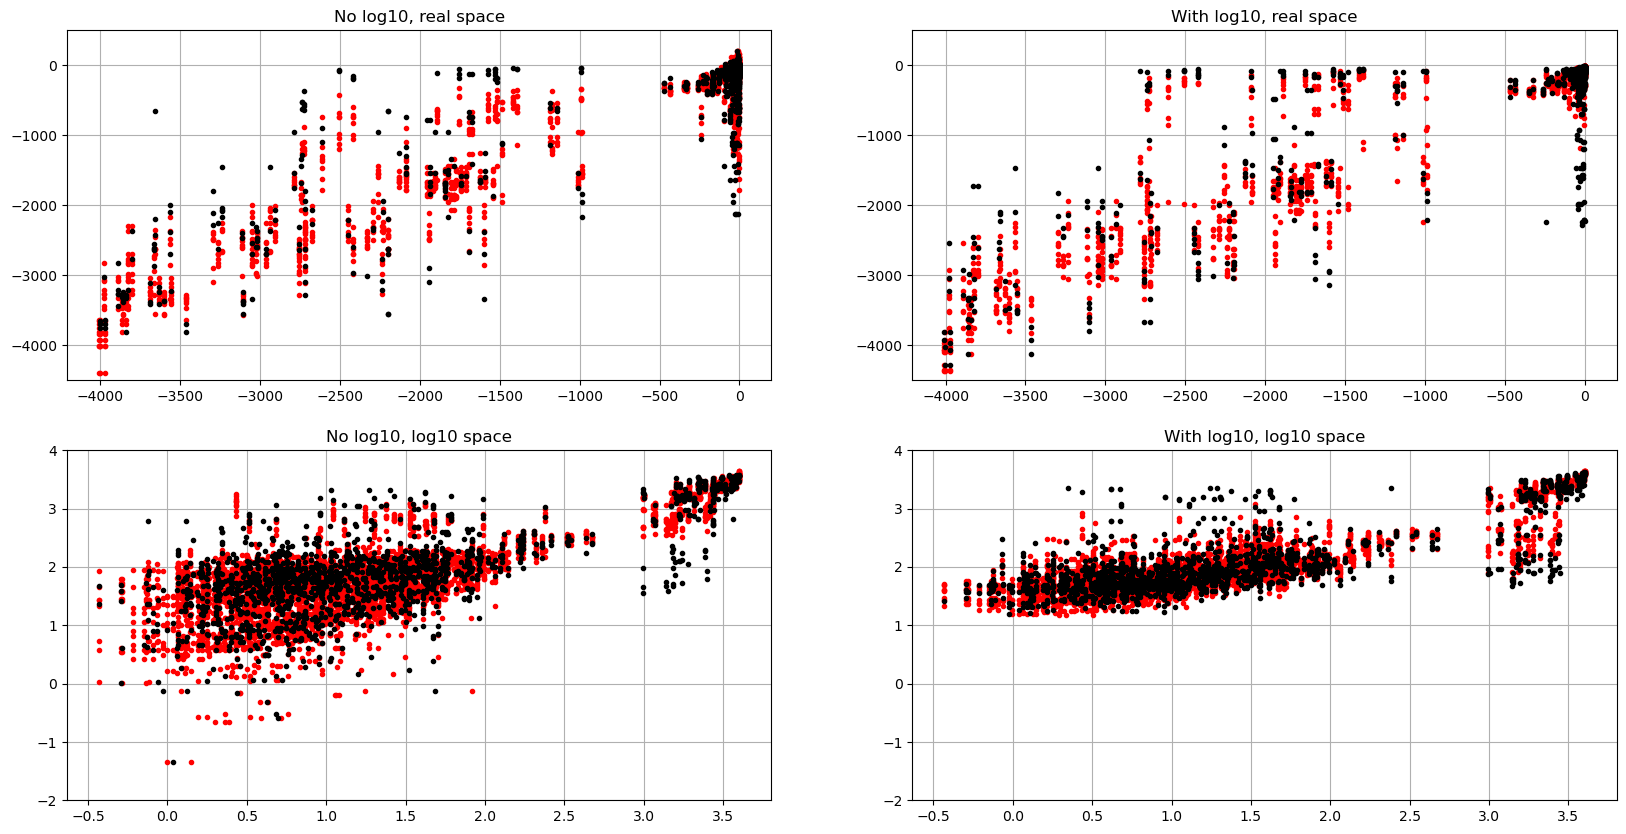

In [9]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2,figsize=(20,10))
ax1.plot(
    train_target_n_log['target'],
    train_target_n_log['predicted'],'r.')

ax1.plot(
    test_target_n_log['target'],
    test_target_n_log['predicted'],'k.')
ax1.grid()
ax1.set_ylim([-4500, 500])
ax1.title.set_text('No log10, real space')

ax2.plot(
    train_target_w_log['target'],
    train_target_w_log['predicted'],'r.')

ax2.plot(
    test_target_w_log['target'],
    test_target_w_log['predicted'],'k.')
ax2.grid()
ax2.set_ylim([-4500, 500])
ax2.title.set_text('With log10, real space')

ax3.plot(
    np.log10(np.abs(train_target_n_log['target'])),
    np.log10(np.abs(train_target_n_log['predicted'])),'r.')

ax3.plot(
    np.log10(np.abs(test_target_n_log['target'])),
    np.log10(np.abs(test_target_n_log['predicted'])),'k.')
ax3.grid()
ax3.set_ylim([-2, 4])
ax3.title.set_text('No log10, log10 space')

ax4.plot(
    np.log10(np.abs(train_target_w_log['target'])),
    np.log10(np.abs(train_target_w_log['predicted'])),'r.')

ax4.plot(
    np.log10(np.abs(test_target_w_log['target'])),
    np.log10(np.abs(test_target_w_log['predicted'])),'k.')
ax4.grid()
ax4.set_ylim([-2, 4])
ax4.title.set_text('With log10, log10 space')